<a href="https://colab.research.google.com/github/tsakailab/MultivariateAnalysis/blob/main/ipynb/ex_Scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 前処理と変換

特徴量（データフレームの列）の大きさを整える代表的なデータ前処理の手法を学びます．これらの前処理は，特徴量のばらつきの幅や分布の中心を調整します．特定の特徴量を重視・軽視し過ぎる偏ったデータ分析や機械学習を防止したり，数値計算を安定にする効果があります．

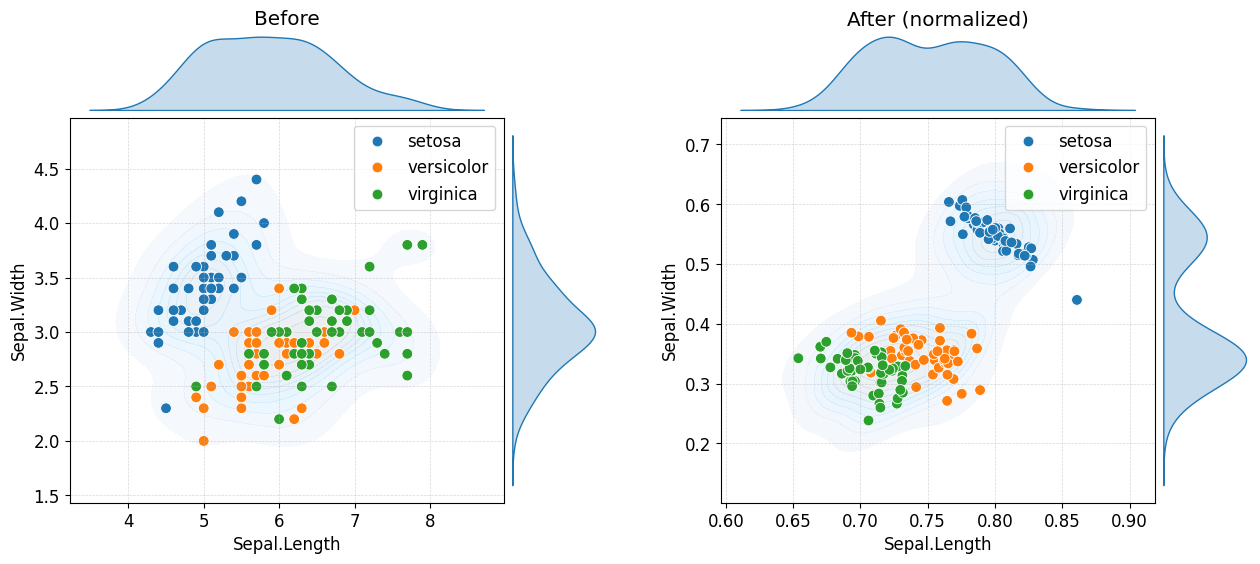

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm

In [ ]:
# --- データセットの読み込み ---
# https://www.statsmodels.org/stable/datasets/index.html
# https://vincentarelbundock.github.io/Rdatasets/datasets.html

# 'mtcars': https://rstudio-pubs-static.s3.amazonaws.com/61800_faea93548c6b49cc91cd0c5ef5059894.html
df = sm.datasets.get_rdataset('mtcars', 'datasets').data

# 'iris': https://rstudio-pubs-static.s3.amazonaws.com/450733_9a472ce9632f4ffbb2d6175aaaee5be6.html
#df = sm.datasets.get_rdataset('iris', 'datasets').data

# 'wine': https://rstudio-pubs-static.s3.amazonaws.com/969152_310d885fec5f4a86842ac74d5c6929f2.html
#from sklearn.datasets import load_wine
#data = load_wine()
#df = pd.DataFrame(data.data, columns=data.feature_names)
#df['target'] = data.target

# toy example:
#df = pd.DataFrame(np.array([[4, 0, 5, 1], [3, 0, 4, 1], [0, 5, 0, 4], [4, 0, 5, 0], [0, 4, 0, 3]]))

print("Number of data: n =", len(df))
print("Available features:", list(df.columns))

In [ ]:
# --- 特徴を選択してください ---
selected_feature = ['wt']
x = df[selected_feature]
print(x.shape)

In [ ]:
# --- 特徴の分布 ---
print(x.agg(['min', 'max']))
plt.figure(figsize=(7, 5))
sns.histplot(x, kde=True, legend=False)
plt.title(f'Original data distribution ("{selected_feature}")')
plt.xlabel('Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 中心化（centering）
各特徴量から，その特徴量の標本平均を引きます．中心化した特徴量の標本平均はゼロになります．

👍 **長所**：特徴量が原点からとても離れた位置に集中して分布しているとき，大きな平均値からの小さなズレによってデータが表されていることになります．平均値を除去することで，データ固有の小さなズレに着目しやすくなります．  
👎 **短所**：データのばらつき（分散）は変わりません．分散に敏感なアルゴリズムを用いる際，中心化だけでは不十分です．  
🎯 **使いどころ**：多変量データのばらつきや内訳を調べる主成分分析（PCA），特徴量を正負の両方に分布させたいときなど．  

In [ ]:
# --- 中心化（centering） ---
x_centered = x - x.mean(axis=0)

# 線形写像で計算してみる（非実用的）
#n = len(x)
#x_centered = (np.eye(n) - np.ones((n,n))/n).dot(x)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(x, kde=True, ax=axes[0], legend=False).set_title('Before')
sns.histplot(x_centered, kde=True, ax=axes[1], facecolor='lightgreen', legend=False).set_title('After (centered)')
plt.show()

----
ちなみに，標本平均は内積で書き表せます．また，中心化は線形写像です．  

$n$ 個のデータの特徴量を成分にもつベクトルを $\boldsymbol{x}=[x^{(1)},\dots,x^{(n)}]^\top\in\mathbb{R}^{n}$，  
すべての成分が 1 の $n$ 次元ベクトルを $\boldsymbol{1}_n=[1,1,\dots,1]^\top\in\mathbb{R}^n$（all-ones vector）とすると，  
特徴量の標本平均は  
$$\hat\mu=\frac{1}{n}\sum_{i=1}^nx^{(i)}=\frac{1}{n}\boldsymbol{1}_n^\top\boldsymbol{x}$$
のように，$\boldsymbol{1}_n$ と $\boldsymbol{x}$ の内積で表せます．$\top$は転置です．  

$\boldsymbol{x}$ を中心化した結果は
$$\hat{\boldsymbol{x}} = \boldsymbol{x} - \frac{1}{n}(\boldsymbol{1}_n^\top \boldsymbol{x})\,\boldsymbol{1}_n$$
または
$$ \hat{\boldsymbol{x}} = \boldsymbol{x}-\frac{1}{n}\boldsymbol{1}_n\boldsymbol{1}_n^\top\boldsymbol{x}=(\boldsymbol{I}_n-\frac{1}{n}\boldsymbol{1}_n\boldsymbol{1}_n^\top)\,\boldsymbol{x}$$
と書き表せます．
ただし，$\boldsymbol{I}_n\in\mathbb{R}^{n\times n}$ は $n$ 次正方の単位行列，$\boldsymbol{1}_n\boldsymbol{1}_n^\top\in\mathbb{R}^{n\times n}$は要素がすべて 1 の $n$ 次正方行列です．

ベクトルや行列のサイズに注意しながら，上記の計算が成り立つことを，いちど丁寧に確認するとよいでしょう．

----

## スケーリング（scaling）

### Min-Maxスケーリング（min-max scaling）
各特徴量ごとに，最小値が 0，最大値が 1 になるようにデータを変換します．

👍 **長所**：データの範囲を一定に揃える，非常に直感的な手法です．変換後の値が必ず [0, 1] の範囲に収まるため，スケールに依存するアルゴリズム（例：データ間の距離に基づく分類など）を用する際に，簡易的な前処理としてよく用いられます．  
👎 **短所**：**外れ値による影響が大きい**です．巨大な外れ値がひとつでもあると，他のほとんどの特徴量が 0 または 1 付近の非常に狭い範囲に押し込められてしまいます．  
🎯 **使いどころ**：画像データのピクセル値（0-255を0-1に変換）など，データの範囲が明確に決まっている場合や，外れ値がないことがわかっている場合に有効です．

$n$ 個のデータについて，特徴量 $x^{(1)},\dots,x^{(n)}$ の最小値と最大値をそれぞれ $x_{\scriptsize\mbox{min}}=\min_i x^{(i)}$，$x_{\scriptsize\mbox{max}}=\max_i x^{(i)}$ とします．$x^{(i)}$ をmin-maxスケーリングした結果は
$$\hat x^{(i)} = \frac{x^{(i)} - x_{\scriptsize\mbox{min}}}{x_{\scriptsize\mbox{max}} - x_{\scriptsize\mbox{min}}}$$
と書き表せます．

In [ ]:
# --- min-max正規化 (min-max scaling) ---
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# 【実習】sklearn を使わないで x_scaled を作りましょう．
# x_min = x.values.min(axis=0)
# x_max = x.values.max(axis=0)
# x_scaled = ?

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(x, kde=True, ax=axes[0], legend=False).set_title('Before')
sns.histplot(x_scaled, kde=True, ax=axes[1], facecolor='lightgreen', legend=False).set_title('After (min-max scaled)')
plt.show()

----
ベクトル $\boldsymbol{x}=[x^{(1)},\dots,x^{(n)}]^\top\in\mathbb{R}^{n}$ を用いると，min-maxスケーリングの結果は次式のように表せます．

$$\hat{\boldsymbol{x}} =
\frac{\boldsymbol{x} - x_{\scriptsize\mbox{min}}\boldsymbol{1}_n}{x_{\scriptsize\mbox{max}}-x_{\scriptsize\mbox{min}}}$$

----

### 標準化（standardization / z-score）

各特徴量の標本平均が 0，標本標準偏差が 1 になるように変換します．

👍 **長所**：正規分布を仮定できる特徴量に対して合理的な前処理です．標準化の特徴量は大きさの期待値が1と仮定できます．Min-maxスケーリングよりも外れ値の影響を受けにくいです．  
👎 **短所**：変換後の値の範囲は一定ではありません（必ずしも [-1, 1] に収まるわけではありません）．  
🎯 **使いどころ**：特徴量の分布が正規分布に近い場合や，どのスケーリング手法を使うか迷った場合に，最も用いられます．


$n$ 個のデータの特徴量 $x^{(1)},\dots,x^{(n)}$ の標本平均と標本分散をそれぞれ $\hat\mu$，$\hat\sigma^2$ とすると，$x^{(i)}$ を標準化した結果は
$$z^{(i)} = \frac{x^{(i)} - \hat\mu}{\hat\sigma}$$
と書き表せます．

In [ ]:
# --- 標準化（standardization）---
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
z = scaler.fit_transform(x)

# 【実習】sklearn を使わないで z を作りましょう．x の標本平均と標本標準偏差は x.mean() と x.std() です．
# z = ?

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(x, kde=True, ax=axes[0], legend=False).set_title('Before')
sns.histplot(z, kde=True, ax=axes[1], facecolor='lightgreen', legend=False).set_title('After (standardized)')
plt.show()

----
ベクトル $\boldsymbol{x}=[x^{(1)},\dots,x^{(n)}]^\top\in\mathbb{R}^{n}$ を用いると，標本平均は $\hat\mu=\frac{1}{n}\boldsymbol{1}_n^\top\boldsymbol{x}$，標本分散は
$$\hat\sigma^2=\frac{1}{n}\sum_{i=1}^n(x^{(i)}-\hat\mu)^2=\frac{1}{n}\|\boldsymbol{x}-\hat\mu\boldsymbol{1}_n\|_2^2$$
と書けるので，標準化の結果 $\boldsymbol{z}=[z^{(1)},\dots,z^{(n)}]^\top\in\mathbb{R}^{n}$ は次式のように表せます．
$$\boldsymbol{z} =
\frac{\boldsymbol{x} - \frac{1}{n}(\boldsymbol{1}_n^\top \boldsymbol{x})\,\boldsymbol{1}_n}
{\frac{1}{\sqrt{n}}\left\|\boldsymbol{x} - \frac{1}{n}(\boldsymbol{1}_n^\top \boldsymbol{x})\,\boldsymbol{1}_n\right\|_2}\;\in\mathbb{R}^n$$

ただし，$\|\boldsymbol{a}\|_2=\sqrt{\boldsymbol{a}^\top\boldsymbol{a}}=\sqrt{\sum_ka_k^2}$ はベクトルの $\ell_2$ノルム（$\ell_2$ norm）です．

----

### ロバストスケーリング（Robust scaling）

 中央値を引き，四分位範囲（interquartile range; IQR）で割ります．IQRは，第3四分位数（75パーセンタイル値）から第1四分位数（25パーセンタイル値）を引いたものです．

👍 **長所**：平均や標準偏差の代わりに中央値と四分位範囲を使うので，外れ値の影響をほとんど受けません．  
👎 **短所**：他の手法に比べてやや計算が複雑です．  
🎯 **使いどころ**：データに外れ値が多く含まれていることが分かっている場合に最も効果的です．

$n$ 個のデータについて，特徴量 $x^{(1)},\dots,x^{(n)}$ の第1四分位数，第2四分位数（中央値），第3四分位数をそれぞれ $q_1$，$q_2$，$q_3$ とします．$x^{(i)}$ をロバストスケーリングした結果は
$$\hat x^{(i)} = \frac{x^{(i)} - q_2}{q_3 - q_1}$$
と書き表せます．分母の$q_3-q_1$がIQRです．

In [ ]:
# --- ロバストスケーリング（robust scaling）---
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

# sklearn を使わないで x_scaled を作りましょう．
#x_scaled = (x - np.median(x)) / (np.percentile(x, 75) - np.percentile(x, 25))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(x, kde=True, ax=axes[0], legend=False).set_title('Before')
sns.histplot(x_scaled, kde=True, ax=axes[1], facecolor='lightgreen', legend=False).set_title('After (robust-scaled)')
plt.show()

---
# 多変量データの前処理

複数の特徴量（多変量）でデータが表されているときは，以下の前処理を検討します．
* (P) 各特徴量（データフレームの列）ごとにスケーリングする
* (N) 各データ点（データフレームの行）ごとに正規化する

In [ ]:
print("Available features:", list(df.columns))
X = df   # 指定した列だけ処理したければ X = df[['mpg', 'hp', 'wp']] のように抜き出す
print(X.shape)

## (P) 各特徴量ごとにスケーリングする

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# 適用したいスケーリングを設定してください
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 2つの特徴量を指定して，スケーリング前後の散布図を観察しましょう
# 横軸と縦軸の特徴量を２つ選んでください
feats = ['wt', 'mpg']  # ['wt', 'mpg', df['vs'].values] # ３つ目があれば色分けに使う

dfXs = [("Before", X[feats[:2]]),
        ("After (scaled)", pd.DataFrame(X_scaled[:,df.columns.get_indexer(feats[:2])], columns=feats[:2]))]

fig, axes = plt.subplots(1, len(dfXs), figsize=(14, 5))
fig.subplots_adjust(wspace=0.5)
plt.rcParams.update({'font.size': 12})
for (_title, _df), _ax in zip(dfXs, axes):
    _ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    sns.kdeplot(ax=_ax, data=_df, x=feats[0], y=feats[1], fill=True, alpha=0.1)
    sns.scatterplot(ax=_ax, data=_df, x=feats[0], y=feats[1], s=60, hue=feats[2] if len(feats)==3 else None).set_title(_title)
    axk = _ax.inset_axes([0, 1.02, 1, 0.2]) # [left, bottom, width, height]
    sns.kdeplot(ax=axk, data=_df, x=feats[0], fill=True)
    axk.axis('off')
    axk = _ax.inset_axes([1.02, 0, 0.2, 1])
    sns.kdeplot(ax=axk, data=_df, y=feats[1], fill=True)
    axk.axis('off')
plt.show()


-----

## (N) 各データ点（データフレームの行）ごとに正規化する

### 正規化（normalization）

$p$ 種類の特徴量がすべて数値のとき，$n$ 行あるデータフレームの各行を $p$ 次元のデータベクトル $\boldsymbol{x}^{(i)}\in\mathbb{R}^p$（$i=1,\dots,n$）と見なし，そのユークリッドノルム（$\ell_2$ノルム，つまり原点からの距離）で割ります．

👍 **長所**：データベクトル $\boldsymbol{x}^{(i)}$ の方向が重要で，大きさ $\|\boldsymbol{x}^{(i)}\|_2$ が重要でない場合に有効です．  
👎 **短所**：他のスケーリングと異なり，特徴量（列ごと）ではなくデータごと（行ごと）に大きさが調整されるので，特徴量の範囲の目安がわかりません．  
🎯 **使いどころ**：コサイン類似度を用いるデータ分類など，ベクトルの向きが重要なときに利用されます（例：TF-IDFや，大規模言語モデルの埋め込み表現を用いたテキスト分類など）．

データベクトル $\boldsymbol{x}^{(i)}$ を $\ell_2$正規化した結果 $\hat{\boldsymbol{x}}^{(i)}$ は次式のように表せます．
$$\hat{\boldsymbol{x}}^{(i)} =\frac{\boldsymbol{x}^{(i)}}{\|\boldsymbol{x}^{(i)}\|_2} $$

$\hat{\boldsymbol{x}}^{(i)}$ の$\ell_2$ノルムは 1 です（$\because \|\hat{\boldsymbol{x}}^{(i)}\|_2=\|\boldsymbol{x}^{(i)}\|_2/\|\boldsymbol{x}^{(i)}\|_2=1$）．

---

#### 正規化の前に中心化する利点

データフレームの各特徴量が中心化済みの場合，$\boldsymbol{x}^{(i)}$ の標本平均はゼロになります($\frac{1}{n}\sum_{i=1}^n\boldsymbol{x}^{(i)}=\boldsymbol{0}_p$)．
つまり，$p$ 次元空間 $\mathbb{R}^p$ において，$\boldsymbol{x}^{(i)}$ を位置ベクトルとする $n$ 個のデータ点は，原点を中心に分布しています．
そのような中心化済みのデータ集合は，データベクトル $\boldsymbol{x}^{(i)}$（$i=1,\dots,n$）の方向によってデータの同異がよく表されています．さらに正規化を施すことで，方向に基づくデータ分析が可能になります．

In [ ]:
# --- 正規化（normalization）---
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
X_normalized = scaler.fit_transform(X)

# sklearn を使わないで X_normalized を作りましょう．
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
#X_normalized = X.values / np.linalg.norm(X, axis=1, keepdims=True)

In [ ]:
# 中心化してから正規化する場合
scaler = Normalizer()
X_normalized = scaler.fit_transform(X - X.mean(axis=0))

In [ ]:
# 2つの特徴量を指定して，スケーリング前後の散布図を観察しましょう
# 横軸と縦軸の特徴量を２つ選んでください
feats = ['wt', 'mpg']  # ['wt', 'mpg', df['vs'].values] # ３つ目があれば色分けに使う

dfXs = [("Before", X[feats[:2]]),
        ("After (normalized)", pd.DataFrame(X_normalized[:,df.columns.get_indexer(feats[:2])], columns=feats[:2]))]

fig, axes = plt.subplots(1, len(dfXs), figsize=(14, 5))
fig.subplots_adjust(wspace=0.5)
plt.rcParams.update({'font.size': 12})
for (_title, _df), _ax in zip(dfXs, axes):
    _ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    sns.kdeplot(ax=_ax, data=_df, x=feats[0], y=feats[1], fill=True, alpha=0.1)
    sns.scatterplot(ax=_ax, data=_df, x=feats[0], y=feats[1], s=60, hue=feats[2] if len(feats)==3 else None).set_title(_title)
    axk = _ax.inset_axes([0, 1.02, 1, 0.2]) # [left, bottom, width, height]
    sns.kdeplot(ax=axk, data=_df, x=feats[0], fill=True)
    axk.axis('off')
    axk = _ax.inset_axes([1.02, 0, 0.2, 1])
    sns.kdeplot(ax=axk, data=_df, y=feats[1], fill=True)
    axk.axis('off')
plt.show()


---
# 補遺：コードの計算式 と 数学の数式の違いを理解しよう

pandasのデータフレームやnumpy配列の計算式は，ほとんど数学の数式そのものに見えるので，可読性が高いです．
しかし，数学の行列やベクトルの演算と異なり，定義が拡張されていること注意が必要です．
コードと数学の違いをよく理解し，意図どおりの計算を記述できていることに注意を払いながらコーディングしてください．計算の結果ではなく，計算の過程が正しいことを確認することが重要です．
また，レポートや論文では，コードの計算式ではなく，数学の数式で説明することが広く読者に受け入れられます．最も避けるべきは，両者を混同して記述することです．

### 例題１：中心化

`X` を，pandasのデータフレームまたはnumpy配列とします．下記の計算式で中心化できます．
```python
   X_centered = X - X.mean(axis=0)
```
右辺で引き算が実行されていますが， `X` と `X.mean()` の `shape` は同じではありません．

In [ ]:
X = np.array([[1, 2, 10, 20],
              [3, 4, 30, 40],
              [5, 6, 50, 60]])
print("X.shape              =", X.shape)

Xmean = X.mean(axis=0)
print("X.mean(axis=0)       =", Xmean)
print("X.mean(axis=0).shape =", Xmean.shape)

X_centered = X - X.mean(axis=0)

print(X_centered)

`X` は 2 次元配列，`X.mean(axis=0)` は 1 次元配列です．
どのように `X` から `X.mean(axis=0)` が減算されているのか，計算過程を意識してください．

`shape`の末尾が一致しているときに計算が成立します．この例では 4 で一致しており， 3 行ある `X` のそれぞれの行から同様に，`X.mean(axis=0)` が減算されます．

このように，`shape` が異なる場合に演算を拡張する機能をブロードキャスト（broadcasting）と言います．

### 例題２：数学関数の適用

numpy の数学関数（`exp` や `log` など）は，pandasのデータフレームやnumpy配列を引数に与えることができます．

例えば，下記の計算式 `np.log(X)` は，`X` のすべての要素に同様に対数が適用されています．しかし，数学の行列 $\boldsymbol{X}$ の対数 $\log\boldsymbol{X}$ は，このように定義されていません．

In [ ]:
print(np.log(X))

`X**2` は `X` の各要素が二乗が計算されます．`X * X` と同じです．
この計算を数学では $\boldsymbol{X}^2$ とは書きません．

In [ ]:
print(X**2)
print(X*X)